This notebook calculates the topic model of the craving set, it clusters into 10 different topics

In [1]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ 
#Run in python console
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TheaK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [9]:
# Import Dataset
df = pd.read_csv("green_eng_tweets_100123.csv")
df = df.rename(columns={"Tweets": "post"})
df

,post
0,With #Germany experiencing usually high temper...
1,Every minute one garbage truck of plastic is d...
2,"Can you imagine a world with fewer cars, no tr..."
3,Driving #sustainability: Henkel Colombia prese...
4,RT @michaelmenhart: Five solar-powered kiosks ...
...,...
22613,"At Allianz, #diversity plays an important role..."
22614,RT @UNEnvironment: Humankind represents just 0...
22615,As a world-leading supplier of high-tech #poly...
22616,RT @adidasrunning: There is a new dawn for run...


In [10]:
# Convert to list
data = df.post.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', post) for post in data]

# Remove distracting single quotes
data = [re.sub("\'", "", post) for post in data]

pprint(data[:1])

['With #Germany experiencing usually high temperatures, is this summers '
 '#ExtremeWeather trend expected to continue? Read Eberhard Fausts expert '
 'opinion on large-scale weather patterns, #climatechange and preparing for '
 'the unpredictable. #natcat2018 https://t.co/e7TxMo2Vuu']


In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

data_words = [[word for word in words if len(word)>2] for words in data_words]    

print(data_words[:1])

[['with', 'germany', 'experiencing', 'usually', 'high', 'temperatures', 'this', 'summers', 'extremeweather', 'trend', 'expected', 'continue', 'read', 'eberhard', 'fausts', 'expert', 'opinion', 'large', 'scale', 'weather', 'patterns', 'climatechange', 'and', 'preparing', 'for', 'the', 'unpredictable', 'natcat', 'https', 'txmo', 'vuu']]


In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['with', 'germany', 'experiencing', 'usually', 'high', 'temperatures', 'this', 'summers', 'extremeweather', 'trend', 'expected', 'continue', 'read', 'eberhard', 'fausts', 'expert', 'opinion', 'large_scale', 'weather', 'patterns', 'climatechange', 'and', 'preparing', 'for', 'the', 'unpredictable', 'natcat', 'https', 'txmo', 'vuu']


In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

c:\Users\TheaK\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[['experience', 'usually', 'high', 'temperature', 'summer', 'extremeweather', 'trend', 'expect', 'continue', 'read', 'eberhard', 'faust', 'expert', 'opinion', 'large_scale', 'weather', 'pattern', 'climatechange', 'prepare', 'unpredictable']]


In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]]


In [16]:
id2word[0]

'climatechange'

In [17]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('climatechange', 1),
  ('continue', 1),
  ('eberhard', 1),
  ('expect', 1),
  ('experience', 1),
  ('expert', 1),
  ('extremeweather', 1),
  ('faust', 1),
  ('high', 1),
  ('large_scale', 1),
  ('opinion', 1),
  ('pattern', 1),
  ('prepare', 1),
  ('read', 1),
  ('summer', 1),
  ('temperature', 1),
  ('trend', 1),
  ('unpredictable', 1),
  ('usually', 1),
  ('weather', 1)]]

In [18]:
import time
# Build LDA model
numTopicsRange = [3,4,5,7,10,12,15]
validationPerplexity = []
coherences = []
umass_coherences = []
uci_coherences = []
npmi_coherences = []
timeElapsed = []
lda_models = []
for i in numTopicsRange:
    start = time.time()
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    end = time.time()
    validationPerplexity.append(lda_model.log_perplexity(corpus))
    coherences.append(CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v').get_coherence())
    umass_coherences.append(CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass').get_coherence())
    uci_coherences.append(CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_uci').get_coherence())
    npmi_coherences.append(CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_npmi').get_coherence())
    lda_models.append(lda_model)
    timeElapsed.append(end-start) 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(9, 3.5), dpi=1600)
seconds = [t/100 for t in timeElapsed]
plt.plot(numTopicsRange,validationPerplexity, color = 'r', label = 'Validation perplexity')
#plt.plot(numTopicsRange,seconds, color = 'b', label = 'time elapsed')
plt.xticks(numTopicsRange)
plt.xlabel("Number of Topics")
plt.legend(loc='upper left')
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(9, 3.5), dpi=1600)
seconds = [t/100 for t in timeElapsed]
plt.plot(numTopicsRange,coherences, color = 'b', label = 'Coherence Score')
#plt.plot(numTopicsRange,seconds, color = 'b', label = 'time elapsed')
plt.xticks(numTopicsRange)
plt.xlabel("Number of Topics")
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Print the Keyword in the 10 topics
best_idx = 4
pprint(lda_models[best_idx].print_topics())
doc_lda = lda_models[best_idx][corpus]

[(0,
  '0.084*"new" + 0.057*"environment" + 0.037*"innovation" + 0.025*"way" + '
  '0.023*"production" + 0.017*"resource" + 0.016*"plant" + 0.014*"start" + '
  '0.014*"become" + 0.011*"polymer"'),
 (1,
  '0.044*"work" + 0.030*"get" + 0.022*"good" + 0.015*"offer" + '
  '0.014*"climateaction" + 0.012*"right" + 0.012*"award" + 0.011*"leader" + '
  '0.010*"fast" + 0.010*"recycle"'),
 (2,
  '0.091*"amp" + 0.054*"learn" + 0.041*"green" + 0.019*"time" + 0.017*"join" + '
  '0.016*"cop" + 0.015*"proud" + 0.015*"project" + 0.015*"nature" + '
  '0.011*"research"'),
 (3,
  '0.263*"https" + 0.057*"sustainability" + 0.051*"sustainable" + 0.030*"make" '
  '+ 0.028*"solution" + 0.024*"use" + 0.013*"industry" + 0.012*"support" + '
  '0.011*"waste" + 0.010*"together"'),
 (4,
  '0.058*"emission" + 0.032*"http" + 0.031*"solar" + 0.031*"combine" + '
  '0.028*"car" + 0.025*"solarimpulse" + 0.024*"reduce" + 0.020*"report" + '
  '0.013*"carbon" + 0.010*"local"'),
 (5,
  '0.050*"future" + 0.037*"technology" + 

In [ ]:
print(lda_models[best_idx].top_topics(corpus))

[([(0.04878632, 'climate'), (0.029793607, 'help'), (0.02791215, 'today'), (0.024032056, 'world'), (0.022179723, 'business'), (0.020416869, 'find'), (0.020019822, 'change'), (0.019106928, 'take'), (0.01828421, 'global'), (0.01656193, 'need'), (0.013837731, 'great'), (0.013366362, 'challenge'), (0.0129523035, 'day'), (0.012596609, 'people'), (0.012344626, 'city'), (0.01232788, 'innovative'), (0.011013548, 'say'), (0.0104902, 'company'), (0.010477005, 'key'), (0.010432101, 'idea')], -3.5791733061133115), ([(0.2630054, 'https'), (0.05663243, 'sustainability'), (0.05114303, 'sustainable'), (0.030048959, 'make'), (0.027568951, 'solution'), (0.02379201, 'use'), (0.012733551, 'industry'), (0.011898052, 'support'), (0.011132679, 'waste'), (0.009684737, 'together'), (0.008686643, 'product'), (0.007977367, 'develop'), (0.00794399, 'well'), (0.0077759675, 'lead'), (0.007359667, 'symrise'), (0.007335388, 'water'), (0.006521161, 'partner'), (0.0063930354, 'grow'), (0.006023886, 'initiative'), (0.006

In [ ]:
sent_topics_df = pd.DataFrame()
for i, row_list in enumerate(doc_lda):
        row = row_list[0] if lda_models[best_idx].per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_models[3].show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
sent_topics_df


KeyboardInterrupt: ignored

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_models[best_idx].log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_models[best_idx], texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.405038597053125

Coherence Score:  0.31171964414952297


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_models[best_idx], corpus, id2word)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.392931  0.039436       1        1  19.099862
6     -0.000246 -0.361388       2        1  14.200602
9      0.038932  0.068990       3        1  11.368503
2      0.037647  0.041803       4        1  10.372141
4      0.058321  0.037063       5        1   9.230367
0      0.045087  0.035996       6        1   8.274244
8      0.051801  0.038315       7        1   7.744513
5      0.049515  0.031744       8        1   7.209561
7      0.055646  0.034241       9        1   6.349851
1      0.056228  0.033800      10        1   6.150357, topic_info=                Term          Freq         Total Category  logprob  loglift
9              https  13647.000000  13647.000000  Default  30.0000  30.0000
136              amp   2577.000000   2577.000000  Default  29.0000  29.0000
85    sustainability   2939.000000   2939.000000  Default  28.0000  28.0000
73               new   1890.000000   1890.000000  Default  27.0000  27.0000
86       sustainable   2654.000000   2654.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
151         position     96.449256     97.308893  Topic10  -5.1546   2.7798
2308      profitable     94.346787     95.207211  Topic10  -5.1767   2.7796
1871            line     91.183676     92.043353  Topic10  -5.2108   2.7793
505           engine     88.329487     89.189224  Topic10  -5.2426   2.7790
6773     adidasrunne     88.399682     89.274328  Topic10  -5.2418   2.7788

[331 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
570       3  0.998160       achieve
1106      8  0.994939           add
6773     10  0.985726   adidasrunne
1231      7  0.996370   agriculture
1520      1  0.997771           aim
...     ...       ...           ...
475      10  0.998485          work
68        2  0.998966         world
185       7  0.999301          year
503      10  0.996045     yesterday
457       9  0.996564  zeroemission

[305 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 10, 3, 5, 1, 9, 6, 8, 2])

IndexError: ignored

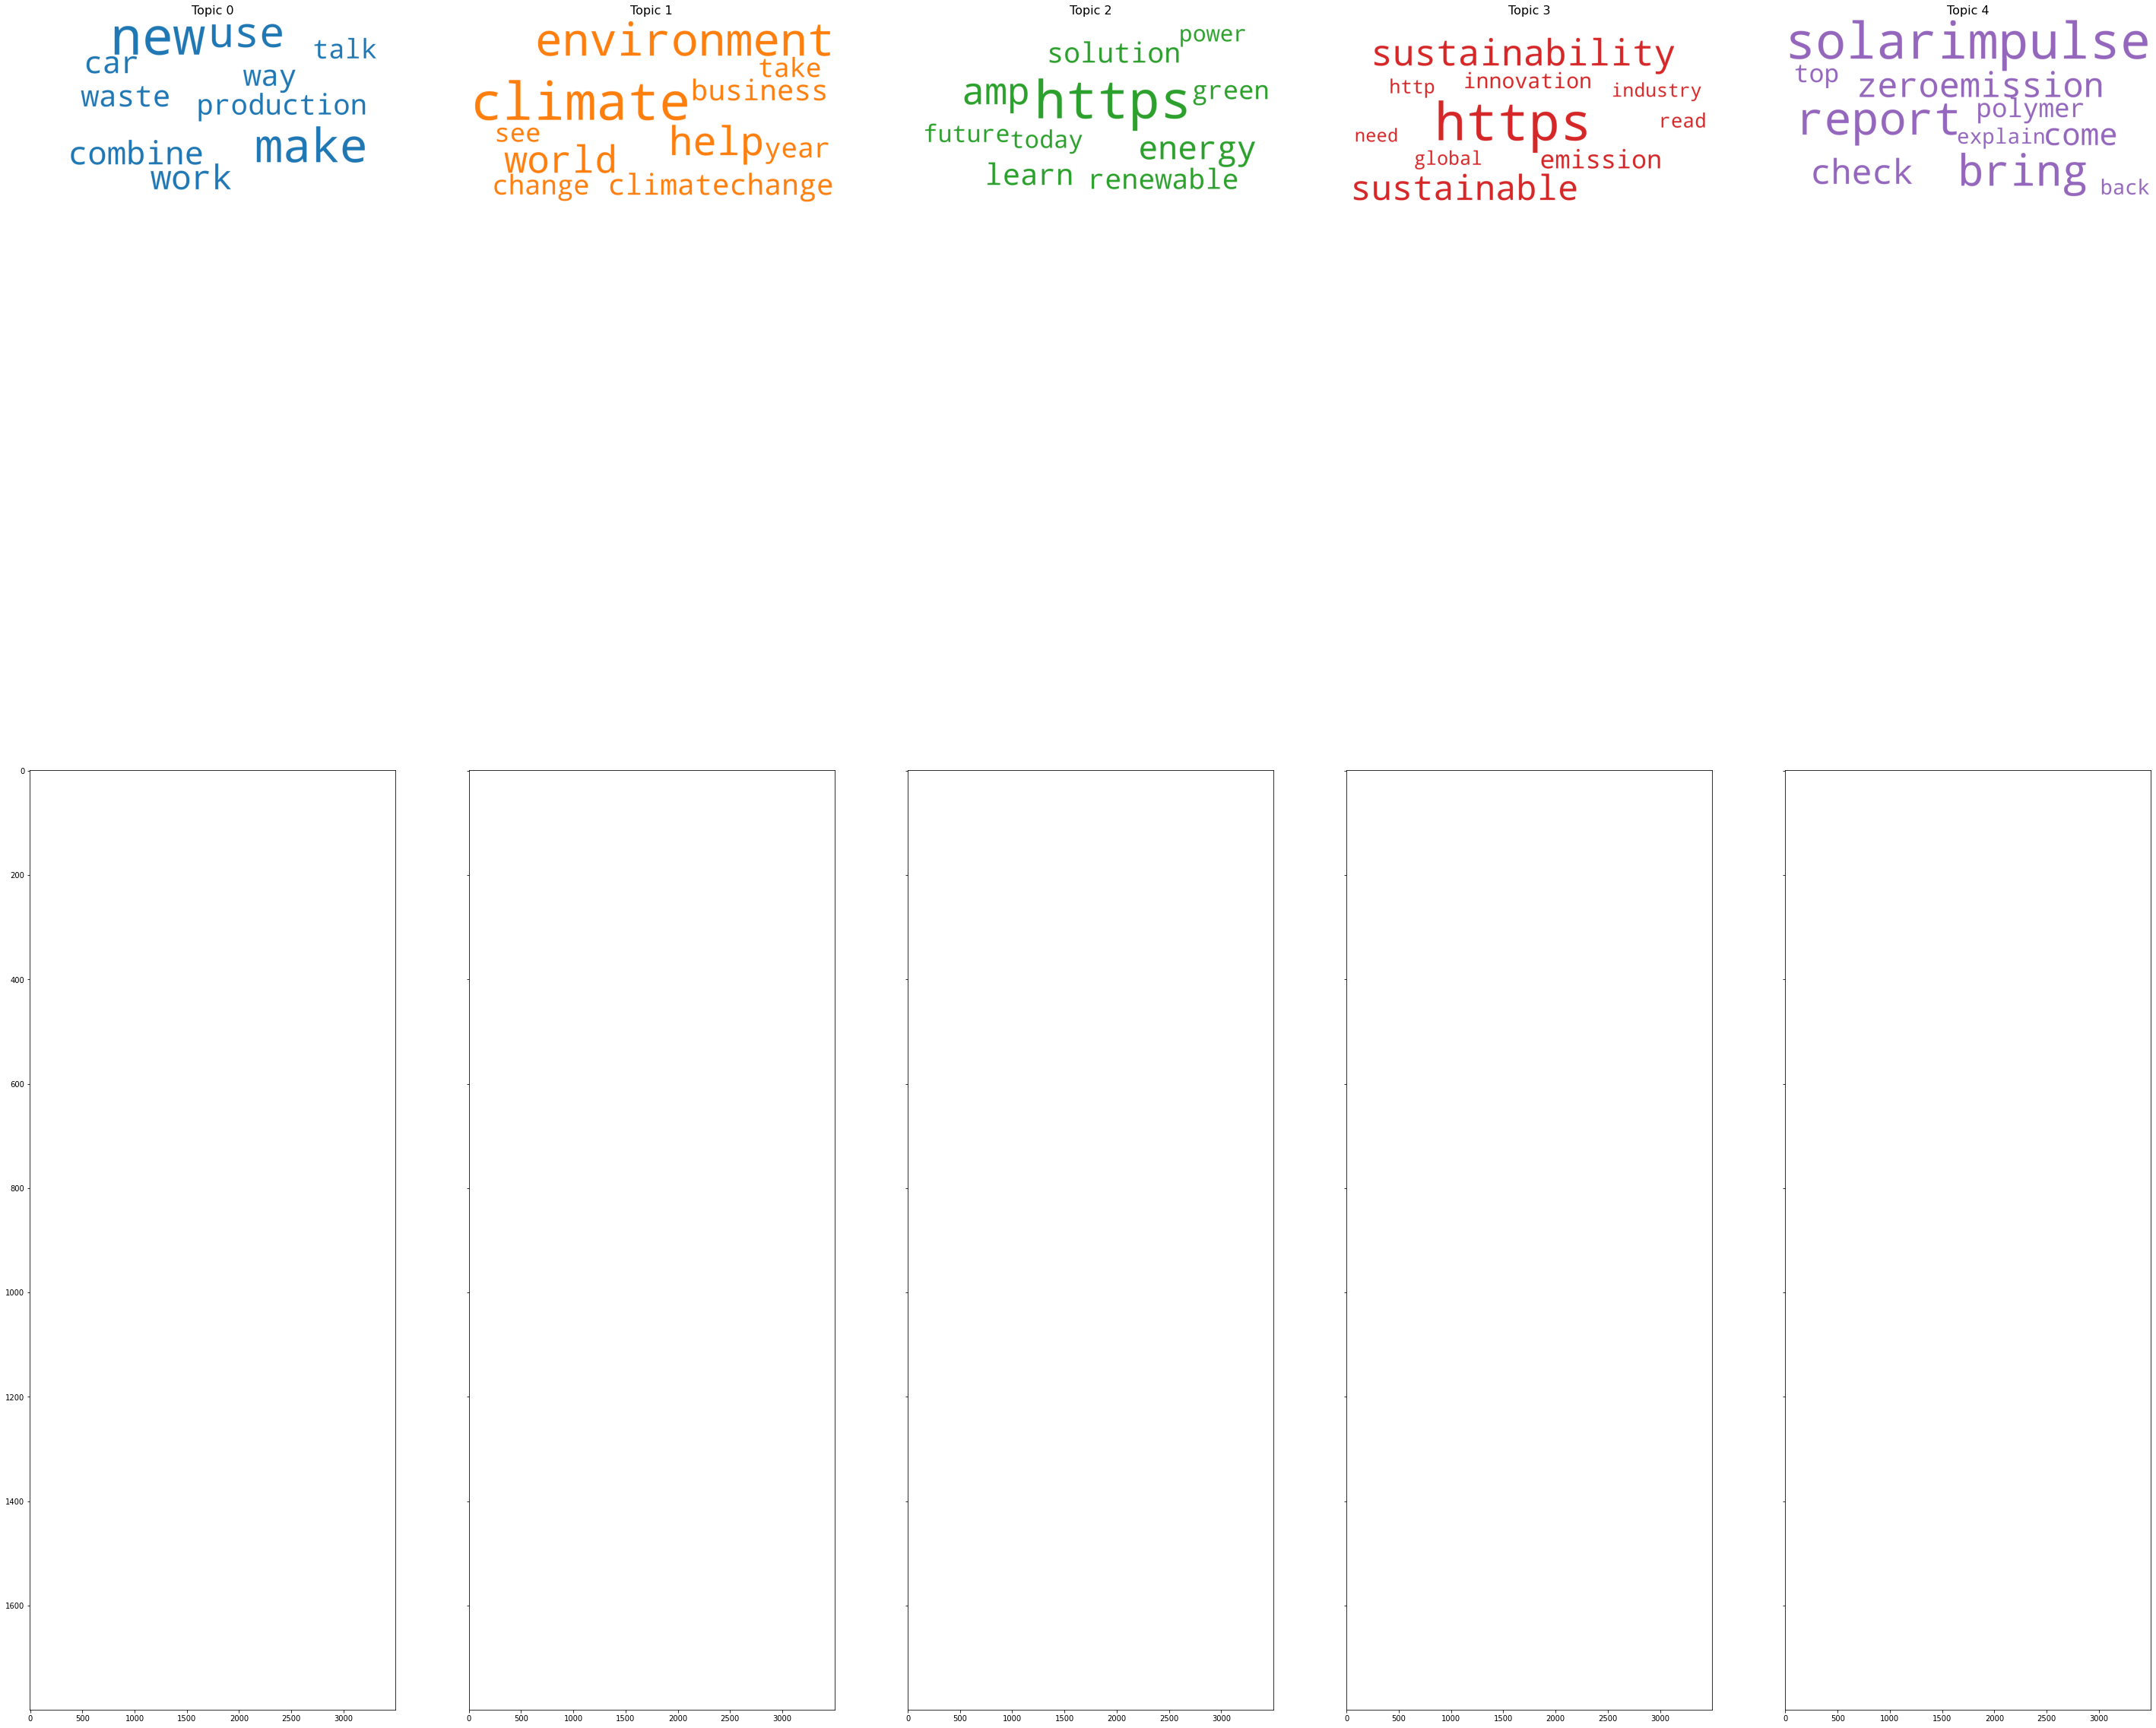

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=3500,
                  height=1800,
                  max_words=14,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_models[best_idx].show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(50,50), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.figure(figsize=(9, 3.5), dpi=1600)
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
'''plt.savefig("wordclouds", 
                          dpi=3600,
                          facecolor='w',
                          edgecolor='w',
                          orientation='portrait',
                          papertype=None, 
                          format=None,
                          transparent=False,
                          bbox_inches=None, 
                          pad_inches=0.1,
                          frameon=None, 
                          metadata=None)'''

In [ ]:
pyLDAvis.save_html(vis, 'lda.html')